In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams, colors
import plotly.express as px
import re
import glob
import lightkurve as lk
import astropy.units as u

%matplotlib inline
# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams['axes.formatter.useoffset'] = False

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

%load_ext autoreload
%autoreload 2

## Kelt 1b investigation

### Assemble dataset

In [2]:
# start with exoclock's database
exoclock_data = pd.read_csv("./data/ExoClock/all_mid_time_data.txt", sep="\s+").sort_values("transit_time")
exoclock_data = exoclock_data[exoclock_data.planet == "KELT-1b"].reset_index(drop=True).drop(columns=["planet", "ID"])  # includes TESS 2019
exoclock_data.source = exoclock_data.source.map({"literature": "ExoClock_Literature", "exoclock": "ExoClock_Original", "space": "ExoClock_TESS"})
exoclock_data

,transit_time,error,source
0,2455899.55407,0.00043,ExoClock_Literature
1,2455899.55500,0.00100,ExoClock_Literature
2,2455905.63858,0.00083,ExoClock_Literature
3,2455909.29289,0.00028,ExoClock_Literature
4,2455911.72553,0.00044,ExoClock_Literature
5,2455927.55574,0.00041,ExoClock_Literature
6,2455933.64320,0.00040,ExoClock_Literature
7,2456180.79690,0.00220,ExoClock_Literature
8,2456182.01420,0.00230,ExoClock_Literature
9,2456583.78510,0.00060,ExoClock_Literature


In [3]:
etd_data = pd.read_csv("./data/ETD/ORIGINALS/ETD_KELT-1_og.txt", sep="\t", names=["index", "epoch", "transit_time", "error", "data_quality", "observer"]).loc[:, ["transit_time", "error"]].sort_values("transit_time")
etd_data["source"] = "ETD"
etd_data

,transit_time,error,source
0,2455899.55407,0.00042,ETD
1,2455899.55497,0.00100,ETD
2,2455905.63859,0.00083,ETD
3,2455911.72553,0.00044,ETD
4,2455927.55574,0.00040,ETD
5,2455933.64320,0.00040,ETD
6,2456251.40441,0.00106,ETD
7,2456488.82856,0.00114,ETD
8,2456505.86486,0.00085,ETD
9,2456520.48534,0.00147,ETD


In [4]:
basturk_data = pd.read_csv("./data/Papers/basturk_2023.txt", sep="\s+", skiprows=15, names=["transit_time", "error", "source"])
basturk_data.source = basturk_data.source.map({1: "Basturk_ETD", 2: "Basturk_Literature", 3: "Basturk_Original", 4: "Baskturk_TESS"}) # 1: ETD, 2: Literature, 3: Our, 4: TESS
basturk_data

,transit_time,error,source
0,2456559.43557,0.00094,Basturk_ETD
1,2456928.33600,0.00079,Basturk_ETD
2,2456962.42565,0.00052,Basturk_ETD
3,2457023.30076,0.00076,Basturk_ETD
4,2457292.36779,0.00071,Basturk_ETD
5,2457387.33030,0.00078,Basturk_ETD
6,2455899.55403,0.00115,Basturk_Literature
7,2455905.63939,0.00087,Basturk_Literature
8,2455911.72745,0.00037,Basturk_Literature
9,2455927.55577,0.00038,Basturk_Literature


In [5]:
HOUR_IN_DAYS = 1 / 24
HOUR_IN_DAYS

0.041666666666666664

In [6]:
PERIOD = 1.21749

In [52]:
df = pd.concat([exoclock_data, etd_data, basturk_data]).sort_values("transit_time").drop_duplicates(["transit_time"]).reset_index(drop=True)
df["epoch"] = ((df.transit_time - df.transit_time[0]) / PERIOD).round()
df[df.duplicated(["epoch"])]

,transit_time,error,source,epoch
1,2455899.55407,0.00042,ETD,0.00000
2,2455899.55497,0.00100,ETD,0.00000
3,2455899.55500,0.00100,ExoClock_Literature,0.00000
5,2455905.63859,0.00083,ETD,5.00000
6,2455905.63939,0.00087,Basturk_Literature,5.00000
9,2455911.72745,0.00037,Basturk_Literature,10.00000
11,2455927.55577,0.00038,Basturk_Literature,23.00000
13,2455933.64322,0.00037,Basturk_Literature,28.00000
22,2456520.49321,0.00126,ETD,510.00000
24,2456548.47769,0.00023,Basturk_Original,533.00000


In [53]:
df = df.drop_duplicates(["epoch"]).reset_index(drop=True)  # do we need to do this or can we include duplicates fitted by different pipelines?
df

,transit_time,error,source,epoch
0,2455899.55403,0.00115,Basturk_Literature,0.00000
1,2455905.63858,0.00083,ExoClock_Literature,5.00000
2,2455909.29289,0.00028,ExoClock_Literature,8.00000
3,2455911.72553,0.00044,ExoClock_Literature,10.00000
4,2455927.55574,0.00040,ETD,23.00000
5,2455933.64320,0.00040,ETD,28.00000
6,2456179.57685,0.00018,Basturk_Original,230.00000
7,2456180.79690,0.00220,ExoClock_Literature,231.00000
8,2456182.01420,0.00230,ExoClock_Literature,232.00000
9,2456223.40701,0.00045,Basturk_Original,266.00000


How much more data do we now have?

In [353]:
len(etd_data), len(df)

(54, 115)

What do the transit times look like when plotted:

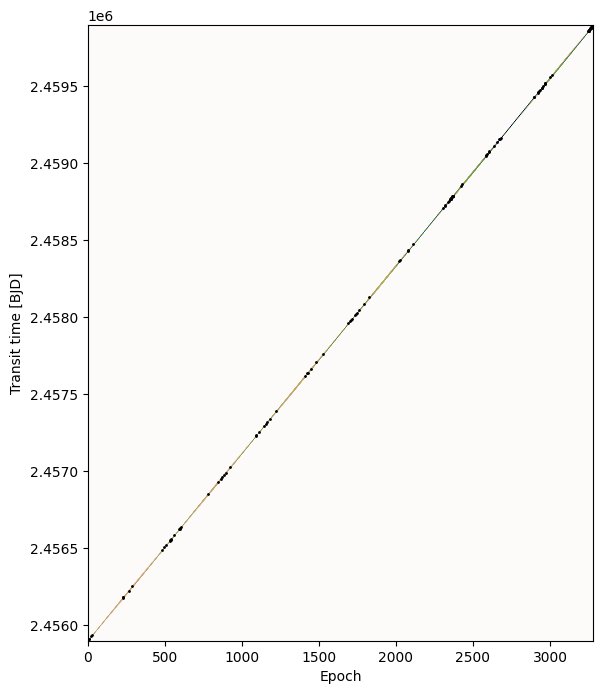

In [54]:
kernel = sp.stats.gaussian_kde(np.vstack([df.epoch, df.transit_time]))

xmin = df.epoch.min()
xmax = df.epoch.max()
ymin = df.transit_time.min()
ymax = df.transit_time.max()
X, Y = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]

positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)

fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(df.epoch, df.transit_time, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.xlabel("Epoch")
plt.ylabel("Transit time [BJD]")
plt.show()

### Fitting

Non-parametric outlier detection:

In [139]:
from code.outlier_detection import non_parametric

survivors, outliers = non_parametric.non_parametric_without_error(df, threshold=0.1)  # remove data-points with empirically less than 1 in 10 thousand chance
df["is_outlier"] = df.index.isin(outliers.index)
outliers

,transit_time,error,source,epoch,is_outlier,residuals
10,2456251.40441,0.00106,ETD,289.00000,True,-0.00574
11,2456488.82856,0.00114,ETD,484.00000,True,0.00719
13,2456520.48534,0.00147,ETD,510.00000,True,0.00915
21,2456631.27622,0.00077,ETD,601.00000,True,0.00812
28,2456990.45854,0.00203,ETD,896.00000,True,0.02989
54,2458362.56329,0.00066,ETD,2023.00000,True,0.01955
57,2458434.36773,0.00222,ETD,2082.00000,True,-0.00812
58,2458473.30435,0.07214,ETD,2114.00000,True,-0.03129
63,2458753.37067,0.00100,ETD,2344.00000,True,0.01154
64,2458764.31209,0.00072,ETD,2353.00000,True,-0.00448


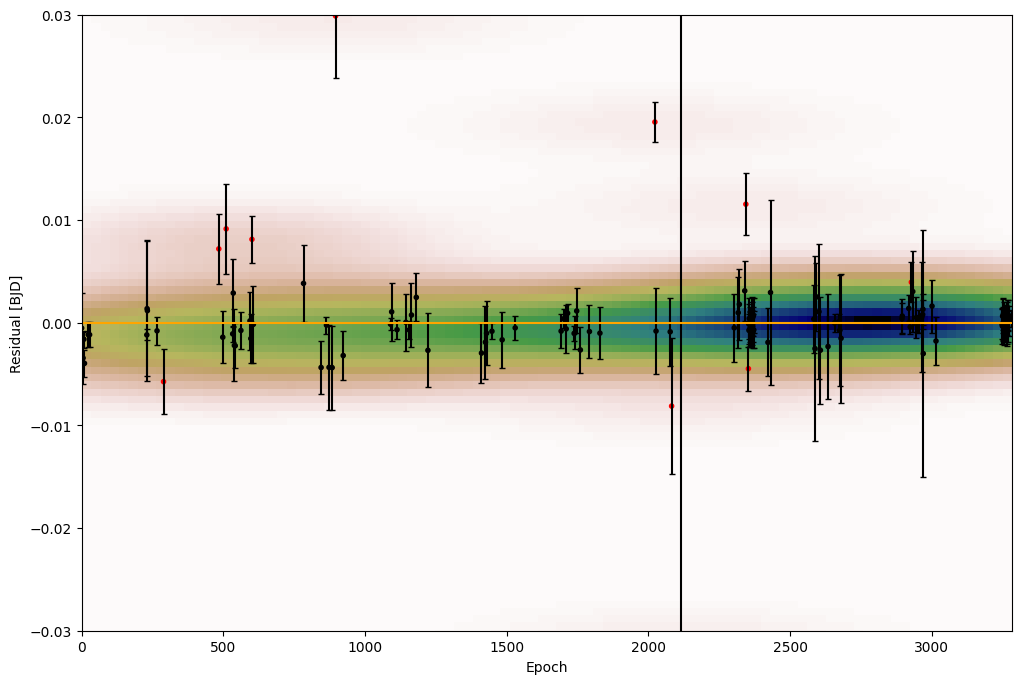

In [140]:
def colors(v):
    if v:
        return "red"
    return "black"
    
X = np.vstack(
    [
        np.power(df.epoch, 0.0),
        np.power(df.epoch, 1.0)
        # do not use a decay term
    ]
).T
y = np.atleast_2d(df.transit_time.values).T
beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
y_hat = (X @ beta).flatten()
residuals = (y.flatten() - y_hat.flatten())

kernel = sp.stats.gaussian_kde(np.vstack([df.epoch, residuals]))

xmin = df.epoch.min()
xmax = df.epoch.max()
ymin = residuals.min() - 0.005
ymax = residuals.max() + 0.005
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)

fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax], aspect="auto")
plt.errorbar(df.epoch, residuals, yerr=3*df.error, fmt=".k", markersize=0, capsize=2)
plt.scatter(df.epoch, residuals, c=df.is_outlier.map(colors), marker=".")
plt.axhline(0, color="orange")
plt.ylabel("Residual [BJD]")
plt.xlabel("Epoch")
plt.ylim((-0.03, 0.03))
plt.show()

In [201]:
from code.fitting import analytical

df = survivors.copy()
beta, t_sigma, posterior_errors, k, t_dof = analytical.bayesian_mvn_regression_fit(df, K0=np.diag([1e-12, 1e-12, 1e-12]))
beta, t_sigma

E[dP/dE] = -0.0037342545056125286 ms/epoch SD[dP/dE] = 0.011804161774055905 Prob(dP/dE < 0) = 0.6248928540340083


(array([[ 2.45589955e+06],
        [ 1.21749396e+00],
        [-4.32205383e-11]]),
 array([[ 3.12927611e-08, -3.53263712e-11,  1.65356396e-14],
        [-3.53263712e-11,  5.93052567e-14, -3.20176490e-17],
        [ 1.65356396e-14, -3.20176490e-17,  1.83438159e-20]]))

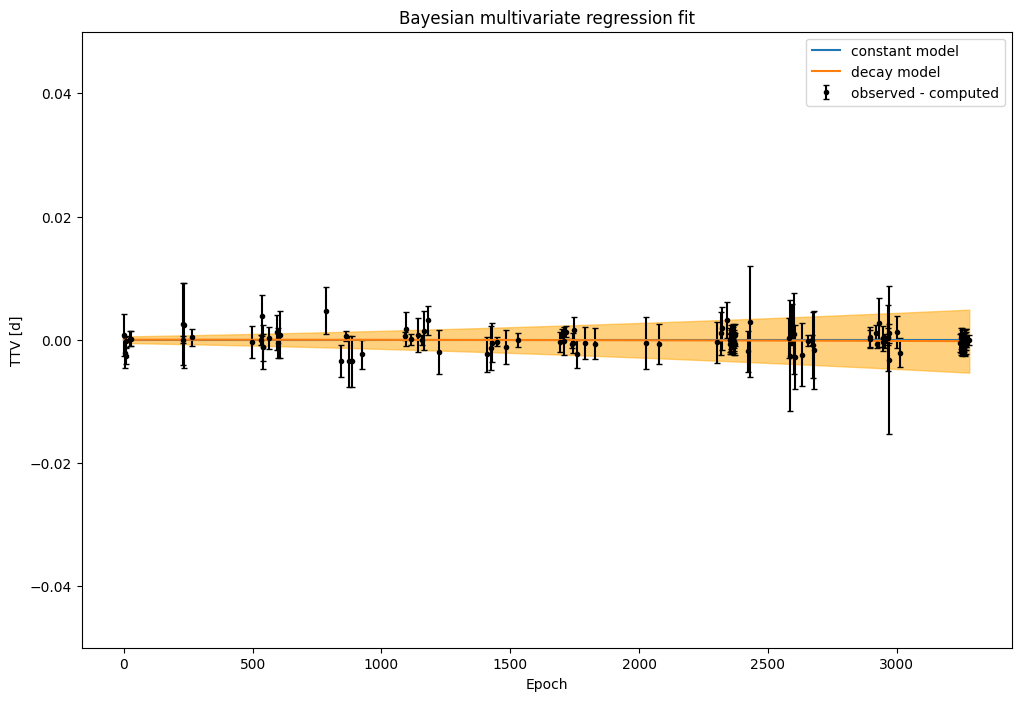

In [203]:
X = np.vstack(
    [
        np.power(df.epoch, 0.0),
        np.power(df.epoch, 1.0),
        0.5 * np.power(df.epoch, 2.0),
    ]
).T
y = np.atleast_2d(df.transit_time.values).T
y_error = 3*np.atleast_2d(df.error.values).T

fit_error = 3*np.atleast_2d(np.sqrt(np.diag(t_sigma))).T
upper_fit = X@(beta+fit_error)
lower_fit = X@(beta-fit_error)

const_beta = np.copy(beta)
const_beta[2, 0] = 0
const_y = X@const_beta
decay_y = X@beta
occ = (y - const_y).flatten()
plt.errorbar(df.epoch, occ, yerr=3*df.error, fmt=".k", capsize=2, label="observed - computed")

deviation = decay_y - const_y
deviation_upper = (upper_fit - const_y).flatten()
deviation_lower = (lower_fit - const_y).flatten()

plt.plot(df.epoch, np.full(occ.shape, 0), label="constant model")
plt.plot(df.epoch, deviation, label="decay model")
plt.ylim([-0.05, 0.05])
plt.fill_between(df.epoch, deviation_upper, deviation_lower, color='orange', alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("TTV [d]")
plt.title("Bayesian multivariate regression fit")
plt.legend()
plt.show()

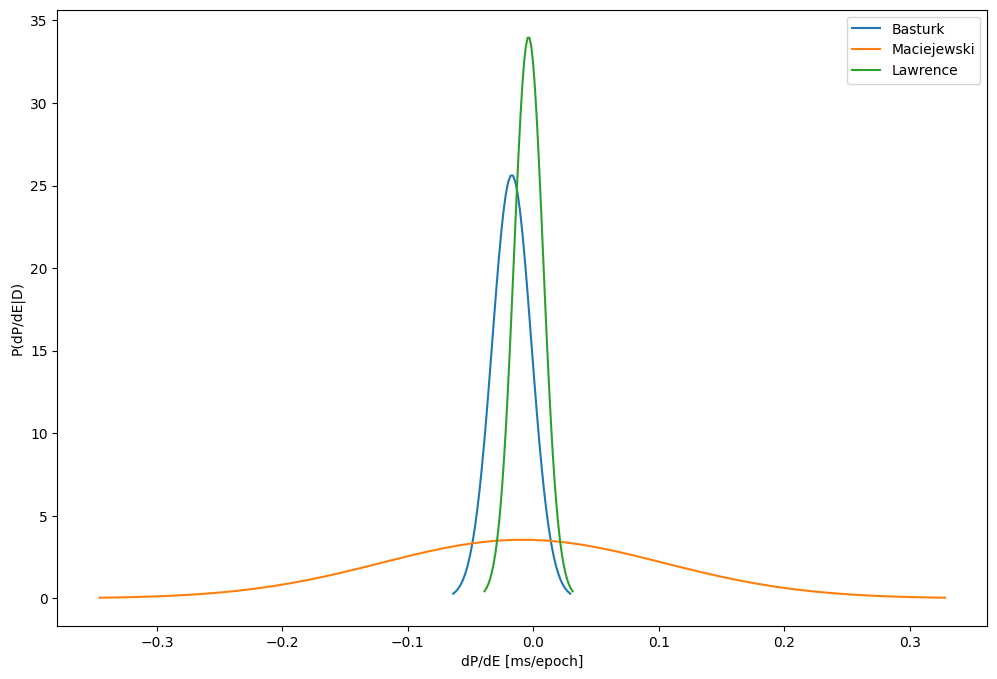

In [205]:
# Basturk: 0.5*dP/dE = (−9.9 ± 4.5)*10−11
mu = -9.9e-11 * 2 * (24 * 60 * 60 * 1000) # ms/epoch
sd = 4.5e-11 * (2**2) * (24 * 60 * 60 * 1000)
x = np.linspace(mu - 3*sd, mu + 3*sd)
plt.plot(x, sp.stats.norm.pdf(x, mu, sd), label="Basturk")

# Maciejewski: (−0.1 ± 1.3) × 10−9
mu = -0.1e-9 * (24 * 60 * 60 * 1000)
sd = 1.3e-9 * (24 * 60 * 60 * 1000)
x = np.linspace(mu - 3*sd, mu + 3*sd)
plt.plot(x, sp.stats.norm.pdf(x, mu, sd), label="Maciejewski")

# Lawrence's fit
mu = beta[2] * (24 * 60 * 60 * 1000)  # ms/epoch
t_sd = np.sqrt(t_sigma[2, 2]) * 24 * 60 * 60 * 1000
x = np.linspace(mu - 3*t_sd, mu + 3*t_sd)
plt.plot(x, sp.stats.t.pdf(x, t_dof, mu, t_sd), label="Lawrence")

plt.xlabel("dP/dE [ms/epoch]")
plt.ylabel("P(dP/dE|D)")
plt.legend()
plt.show()

Compare BIC and chi squared of fitted models

In [223]:
len(df)

115

In [238]:
from code import stats

residuals = stats.compute_residuals(df, beta)
normalised_residuals = residuals / posterior_errors
X2 = np.power(normalised_residuals, 2.0).sum()
X2 / (len(df)+3)

2.6428301351359855

In [239]:
stats.bic(df, beta, k)

-581.2269437788832

### Theory:

In [295]:
earth_radius = 6.378e6  # m
earth_mass = 5.972e24  # kg
solar_radius = 6.957e8 # m
solar_mass = 1.989e30  # kg

In [328]:
# values from Siverd et al 2012
e = 0.0099
Rs = 1.46 * solar_radius # stellar radius
Rp = 12.4420 * earth_radius
Ms = 1.32 * solar_mass
Mp = 8654.15 * earth_mass
a = 0.02466 * sp.constants.au # semi major axis
P = 1.217514

Qs = 10 ** 5.5
Qp = 10 ** 6.5

stellar_tide_da_dt = \
    -(9/2 * ((sp.constants.G / Ms) ** 0.5) * ((Rs ** 5 * Mp) / Qs) * (1 + (57/4 * e ** 2))) * (a ** -5.5)

planetary_tide_da_dt = \
    -(63/2 * ((sp.constants.G * Ms ** 3) ** 0.5) * (Rp ** 5 / (Qp * Mp)) * e ** 2) * (a ** -5.5)

total_da_dt = stellar_tide_da_dt + planetary_tide_da_dt

# using Kepler's third law to convert to dP/dt in ms/year
dP_dt = 3 * sp.constants.pi * np.sqrt(a  / (sp.constants.G * Ms)) * total_da_dt * 365 * 24 * 60 * 60 * 1000

# then converting to ms/epoch
dP_dE = dP_dt * (P / 365)
dP_dE

-0.4400429619363824

In [325]:
stellar_tide_da_dt, planetary_tide_da_dt

(-9.673508083698801e-05, -4.9782253812370225e-11)

In [347]:
observation = (beta[2] * 24 * 60 * 60 * 1000).item()
observation

-0.003734254505612529

How does decay rate vary with Q*?

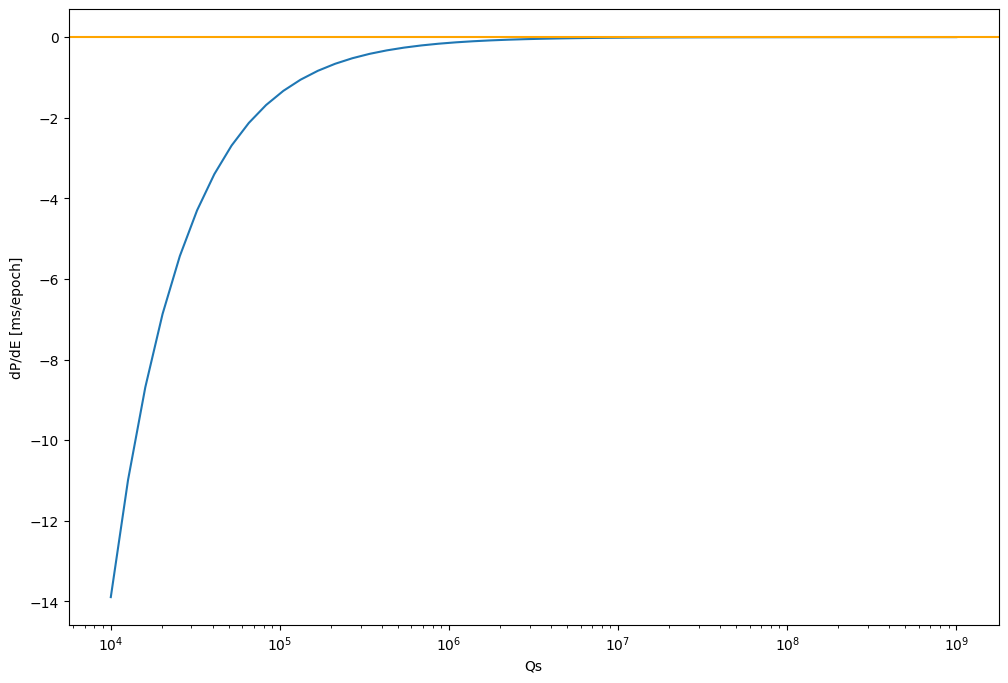

In [350]:
Qs = np.logspace(4, 9)

stellar_tide_da_dt = \
    -(9/2 * ((sp.constants.G / Ms) ** 0.5) * ((Rs ** 5 * Mp) / Qs) * (1 + (57/4 * e ** 2))) * (a ** -5.5)
dP_dt = 3 * sp.constants.pi * np.sqrt(a  / (sp.constants.G * Ms)) * stellar_tide_da_dt * 365 * 24 * 60 * 60 * 1000
dP_dE = dP_dt * (P / 365)

pd.Series(dP_dE, index=Qs).plot(xlabel="Qs", ylabel="dP/dE [ms/epoch]", logx=True, logy=False)
plt.axhline(observation, color="orange")

How does decay rate vary with eccentricity?

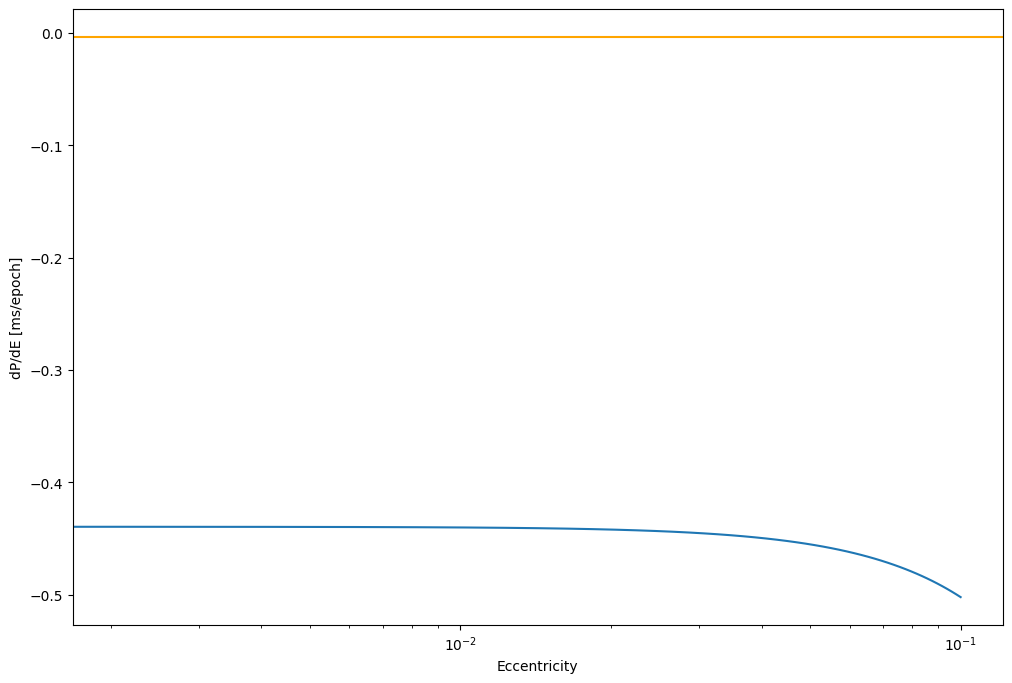

In [351]:
Qs = 10 ** 5.5
e = np.linspace(0, 0.1)

stellar_tide_da_dt = \
    -(9/2 * ((sp.constants.G / Ms) ** 0.5) * ((Rs ** 5 * Mp) / Qs) * (1 + (57/4 * e ** 2))) * (a ** -5.5)
dP_dt = 3 * sp.constants.pi * np.sqrt(a  / (sp.constants.G * Ms)) * stellar_tide_da_dt * 365 * 24 * 60 * 60 * 1000
dP_dE = dP_dt * (P / 365)

pd.Series(dP_dE, index=e).plot(xlabel="Eccentricity", ylabel="dP/dE [ms/epoch]", logx=True, logy=False)
plt.axhline(observation, color="orange")

**NOTE**: the theoretical equations I've been using assume that the planet’s orbital period is short compared with the star’s rotation period. In this case that may not be true!

The latter plot really highlights the discrepancy, and this is something I should rectify in my theoretical calculations.